# Analyse et nettoyage des données Immatriculation

## Import

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import BooleanType, FloatType
from pyspark.sql.functions import trim, lower, col, count, regexp_replace, max, min

## Session spark

In [2]:
spark = SparkSession.builder\
    .appName("CleanImmatriculation")\
    .enableHiveSupport()\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/14 10:58:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Import des données

In [3]:
spark.sparkContext.setLogLevel("OFF")
spark.catalog.clearCache()
spark.sql("USE concessionnaire")

df_immat = spark.sql("SELECT * FROM immatriculations_ext")

df_immat.show()

+---------------+----------+----------------+---------+-----------+--------+--------+-------+--------+-----+
|immatriculation|    marque|             nom|puissance|   longueur|nbplaces|nbportes|couleur|occasion| prix|
+---------------+----------+----------------+---------+-----------+--------+--------+-------+--------+-----+
|      167 JA 42|   Peugeot|        1007 1.4|       75|     courte|       5|       5|  rouge|   false|13750|
|     6956 HM 76|   Renault|     Laguna 2.0T|      170|     longue|       5|       5|   noir|   false|27300|
|      852 KQ 58|    Lancia| Ypsilon 1.4 16V|       90|     courte|       5|       3|   noir|   false|13500|
|     2429 ZQ 52|Volkswagen|    Golf 2.0 FSI|      150|    moyenne|       5|       5|   bleu|   false|22900|
|     5605 XG 92|Volkswagen|     Polo 1.2 6V|       55|     courte|       5|       3|  rouge|   false|12200|
|     4685 DN 33|       BMW|              M5|      507|tr�s longue|       5|       5|  rouge|   false|94800|
|     9849 JL 91|Vo

## Analyse

### Casse
- Renommage de la colonne "nom" en "modele"
- Normalisation des marques
- Normalisation des modèles

In [4]:
#Renommage de la colonne "nom" en "modele"
df_immat = df_immat.withColumnRenamed("nom", "modele")

df_immat.printSchema()

root
 |-- immatriculation: string (nullable = true)
 |-- marque: string (nullable = true)
 |-- modele: string (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- longueur: string (nullable = true)
 |-- nbplaces: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- couleur: string (nullable = true)
 |-- occasion: string (nullable = true)
 |-- prix: integer (nullable = true)



In [5]:
#Normalisation des marques
df_immat = df_immat.withColumn("marque", lower(trim(col("marque"))))

#Normalisation des modèles
df_immat = df_immat.withColumn("modele", lower(trim(col("modele"))))

In [6]:
df_immat.show(n=5)

+---------------+----------+---------------+---------+--------+--------+--------+-------+--------+-----+
|immatriculation|    marque|         modele|puissance|longueur|nbplaces|nbportes|couleur|occasion| prix|
+---------------+----------+---------------+---------+--------+--------+--------+-------+--------+-----+
|      167 JA 42|   peugeot|       1007 1.4|       75|  courte|       5|       5|  rouge|   false|13750|
|     6956 HM 76|   renault|    laguna 2.0t|      170|  longue|       5|       5|   noir|   false|27300|
|      852 KQ 58|    lancia|ypsilon 1.4 16v|       90|  courte|       5|       3|   noir|   false|13500|
|     2429 ZQ 52|volkswagen|   golf 2.0 fsi|      150| moyenne|       5|       5|   bleu|   false|22900|
|     5605 XG 92|volkswagen|    polo 1.2 6v|       55|  courte|       5|       3|  rouge|   false|12200|
+---------------+----------+---------------+---------+--------+--------+--------+-------+--------+-----+
only showing top 5 rows



### Recherche des caractères spéciaux

- Recherche du symbole "�"
- Recherche du caractère "ã©"

In [7]:
#Recherche du symbole "�"

df_search_special_char_immat = df_immat.filter(
    col("immatriculation").like("%�%") | 
    col("marque").like("%�%") | 
    col("modele").like("%�%") | 
    col("longueur").like("%�%") |
    col("couleur").like("%�%") | 
    col("occasion").like("%�%")
)

#Recherche du caractère "ã©"

df_search_special_char_2_immat = df_immat.filter(
    col("immatriculation").like("%ã©%") | 
    col("marque").like("%ã©%") | 
    col("modele").like("%ã©%") | 
    col("longueur").like("%ã©%") |
    col("couleur").like("%ã©%") | 
    col("occasion").like("%ã©%")
)

df_search_special_char_immat.show()
df_search_special_char_2_immat.show()

+---------------+--------+----------------+---------+-----------+--------+--------+-------+--------+------+
|immatriculation|  marque|          modele|puissance|   longueur|nbplaces|nbportes|couleur|occasion|  prix|
+---------------+--------+----------------+---------+-----------+--------+--------+-------+--------+------+
|     4685 DN 33|     bmw|              m5|      507|tr�s longue|       5|       5|  rouge|   false| 94800|
|     9138 JU 10|     bmw|              m5|      507|tr�s longue|       5|       5|   bleu|   false| 94800|
|     8930 WE 91| renault|vel satis 3.5 v6|      245|tr�s longue|       5|       5|   noir|   false| 49200|
|      713 DR 91|     bmw|              m5|      507|tr�s longue|       5|       5|  blanc|   false| 94800|
|     7043 HC 23|   volvo|          s80 t6|      272|tr�s longue|       5|       5|  rouge|   false| 50500|
|     2905 OZ 78|mercedes|            s500|      306|tr�s longue|       5|       5|  rouge|   false|101300|
|     6959 JS 88| renault|ve

+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
|immatriculation|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+



### Correction des caractères spéciaux

- Correction du symbole "�" dans la colonne "longueur".


In [8]:
#Correction du symbole "�" dans la colonne "longueur"

df_immat = df_immat.withColumn("longueur", regexp_replace(col("longueur"), "�", "e"))

df_search_special_char_immat = df_immat.filter(
    col("immatriculation").like("%�%") | 
    col("marque").like("%�%") | 
    col("modele").like("%�%") | 
    col("longueur").like("%�%") |
    col("couleur").like("%�%") | 
    col("occasion").like("%�%")
)

df_search_special_char_immat.show()

+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
|immatriculation|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+



## Recherche et correction des Null

- Recherche des null

In [9]:

#Recherche des null

# Liste des colonnes du DataFrame
colonnes = df_immat.columns

# Filtrer pour conserver uniquement les lignes où au moins une colonne est nulle
df_nulls = df_immat.filter(
    sum(col(colonne).isNull().cast("int") for colonne in colonnes) > 0
)

# Afficher les lignes avec des valeurs nulles
df_nulls.show()

+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
|immatriculation|marque|modele|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+
+---------------+------+------+---------+--------+--------+--------+-------+--------+----+



## Modification du type des colonnes occasion

- Recherche des valeurs d'occasion
- Changer le type de la colonne

In [10]:
#Recherche des valeurs d'occasion
value_count_occasion = df_immat.groupBy("occasion").count()

value_count_occasion.show()

+--------+-------+
|occasion|  count|
+--------+-------+
|   false|1374510|
|    true| 625490|
+--------+-------+



In [11]:
#Changer le type de la colonne
df_immat = df_immat.withColumn("occasion", df_immat["occasion"].cast(BooleanType()))

df_immat.printSchema()

root
 |-- immatriculation: string (nullable = true)
 |-- marque: string (nullable = true)
 |-- modele: string (nullable = true)
 |-- puissance: integer (nullable = true)
 |-- longueur: string (nullable = true)
 |-- nbplaces: integer (nullable = true)
 |-- nbportes: integer (nullable = true)
 |-- couleur: string (nullable = true)
 |-- occasion: boolean (nullable = true)
 |-- prix: integer (nullable = true)



## Recherche de valeurs aberrantes

- Modéliser les valeurs dans un diagramme à moustaches pour mettre en avant les valeurs aberrantes.
- Afficher les valeurs suspectes.

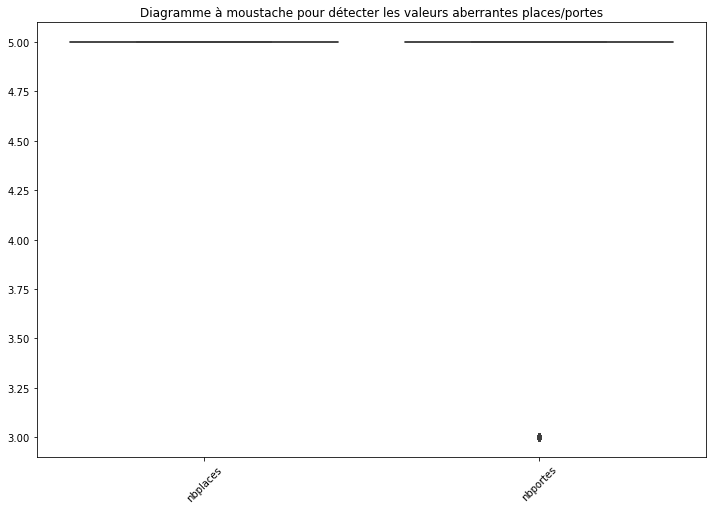

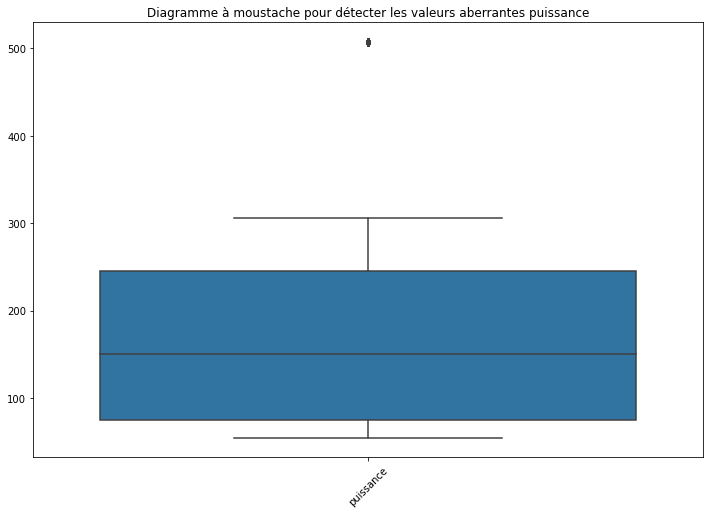

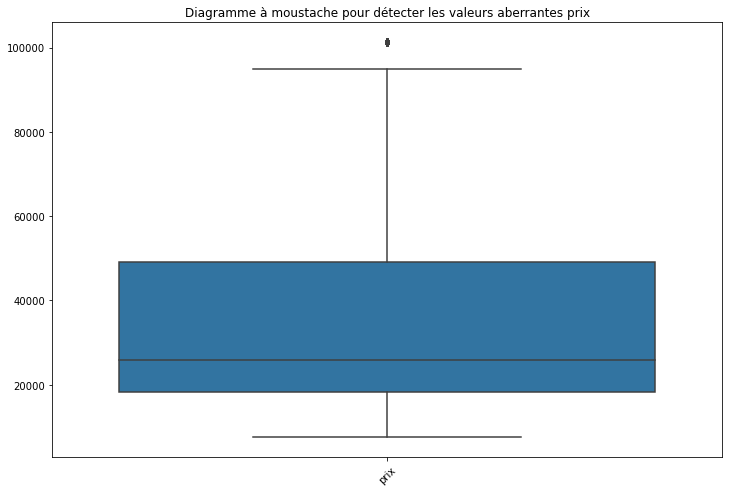

In [12]:
#Modéliser les valeurs dans un diagramme à moustaches pour mettre en avant les valeurs aberrantes.

# 2. Sélectionner uniquement les colonnes numériques nécessaires

df_place_porte = df_immat.select(["nbplaces", "nbportes"])
df_prix = df_immat.select(["prix"])
df_puissance = df_immat.select(["puissance"])

# 3. Convertir le DataFrame PySpark en DataFrame Pandas
df_place_porte= df_place_porte.toPandas()
df_prix= df_prix.toPandas()
df_puissance= df_puissance.toPandas()

# 4. Tracer le diagramme à moustaches pour chaque colonne
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_place_porte)
plt.title("Diagramme à moustache pour détecter les valeurs aberrantes places/portes")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_puissance)
plt.title("Diagramme à moustache pour détecter les valeurs aberrantes puissance")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_prix)
plt.title("Diagramme à moustache pour détecter les valeurs aberrantes prix")
plt.xticks(rotation=45)
plt.show()

In [13]:
#Afficher les valeurs suspectes.

# Trouver la valeur maximale de la colonne "prix"
prix_max = df_immat.select(max("prix")).collect()[0][0]

# Filtrer le DataFrame pour afficher les lignes ayant cette valeur
df_max_prix = df_immat.filter(df_immat["prix"] == prix_max)

# Afficher les lignes avec le prix maximum
df_max_prix.show()

# Trouver la valeur maximale de la colonne "prix"
prix_min = df_immat.select(min("prix")).collect()[0][0]

# Filtrer le DataFrame pour afficher les lignes ayant cette valeur
df_min_prix = df_immat.filter(df_immat["prix"] == prix_min)

# Afficher les lignes avec le prix maximum
df_min_prix.show()

+---------------+--------+------+---------+-----------+--------+--------+-------+--------+------+
|immatriculation|  marque|modele|puissance|   longueur|nbplaces|nbportes|couleur|occasion|  prix|
+---------------+--------+------+---------+-----------+--------+--------+-------+--------+------+
|     2905 OZ 78|mercedes|  s500|      306|tres longue|       5|       5|  rouge|   false|101300|
|     6522 GW 32|mercedes|  s500|      306|tres longue|       5|       5|  rouge|   false|101300|
|     2382 ZY 91|mercedes|  s500|      306|tres longue|       5|       5|  blanc|   false|101300|
|     3144 TP 16|mercedes|  s500|      306|tres longue|       5|       5|   gris|   false|101300|
|      445 MM 39|mercedes|  s500|      306|tres longue|       5|       5|   bleu|   false|101300|
|     5580 NQ 13|mercedes|  s500|      306|tres longue|       5|       5|   noir|   false|101300|
|     6063 JP 83|mercedes|  s500|      306|tres longue|       5|       5|   gris|   false|101300|
|     4724 VB 70|mer